In [1]:
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np
import gc

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#Seed used for all calculations of training and test point indices 
SEED = 14

Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10
eps=0.3


In [3]:
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 50
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

Total Model Params: 3330314
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.test_data, model.test_labels)[1]))

6055/6055 [==============================] - 1s 217us/step
Model Accuracy: 0.99306


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 10
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='NOISY', eps=eps)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [8]:
fgsm_guides = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))

#Whitebox CW Attack
#First get guide images
guide_indices_fgsm = list()
guide_indices_bim_a = list()
guide_indices_bim_b = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for i in range(num_test_samples):
    label_fgsm = np.argmax(fgsm_guides[i])
    label_bim_a = np.argmax(bim_a_guides[i])
    label_bim_b = np.argmax(bim_b_guides[i])
   
    #Get a test point with the target label
    guide_imgs_indices_fgsm = np.where(model.train_labels[:,label_fgsm] == 1)[0]
    guide_imgs_indices_bim_a = np.where(model.train_labels[:,label_bim_a] == 1)[0]
    guide_imgs_indices_bim_b = np.where(model.train_labels[:,label_bim_b] == 1)[0]
    #Choose a guide image
    guide_img_idx_fgsm = np.random.choice(guide_imgs_indices_fgsm, 1)[0]
    guide_img_idx_bim_a = np.random.choice(guide_imgs_indices_bim_a, 1)[0]
    guide_img_idx_bim_b = np.random.choice(guide_imgs_indices_bim_b, 1)[0]


    guide_indices_fgsm.append(guide_img_idx_fgsm)
    guide_indices_bim_a.append(guide_img_idx_bim_a)
    guide_indices_bim_b.append(guide_img_idx_bim_b)


#1 Phase Attack
fgsm_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM-WB', eps=eps, x_tar=model.train_data[guide_indices_fgsm], y_tar = model.train_labels[guide_indices_fgsm])
bim_a_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-A-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_a], y_tar = model.train_labels[guide_indices_bim_a])
bim_b_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-B-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_b], y_tar = model.train_labels[guide_indices_bim_b])

In [9]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)  

Loaded model from disk


In [10]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

#2 Phase Attack 
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [12]:
#Whitebox CW 2 Phase attack with FGSM, BIM-a/b guide images
p2_cw_data_fgsm = model.generate_perturbed_data(fgsm_data, y_tar=model.train_labels[guide_indices_fgsm],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_fgsm], use_cos_norm_reg=True, eps=eps)
p2_cw_data_bim_a = model.generate_perturbed_data(bim_a_data, y_tar=model.train_labels[guide_indices_bim_a],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_a], use_cos_norm_reg=True, eps=eps)
p2_cw_data_bim_b = model.generate_perturbed_data(bim_b_data, y_tar=model.train_labels[guide_indices_bim_b],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_b], use_cos_norm_reg=True, eps=eps)

In [13]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [14]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy NOISY: %.5f' % (model.model.evaluate(noisy_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A: %.5f' % (model.model.evaluate(bim_a_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B: %.5f' % (model.model.evaluate(bim_b_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM-WB: %.5f' % (model.model.evaluate(fgsm_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A WB: %.5f' % (model.model.evaluate(bim_a_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B WB: %.5f' % (model.model.evaluate(bim_b_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW: %.5f' % (model.model.evaluate(cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P1 CW: %.5f' % (model.model.evaluate(p1_cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 CW: %.5f' % (model.model.evaluate(p2_cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 FGSM: %.5f' % (model.model.evaluate(p2_cw_data_fgsm,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 BIM-A: %.5f' % (model.model.evaluate(p2_cw_data_bim_a,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 BIM-B %.5f' % (model.model.evaluate(p2_cw_data_bim_b,model.test_labels[test_indices])[1]))

100/100 [==============================] - 0s 406us/step
Model Accuracy REG: 1.00000
100/100 [==============================] - 0s 172us/step
Model Accuracy NOISY: 0.99000
100/100 [==============================] - 0s 170us/step
Model Accuracy FGSM: 0.20000
100/100 [==============================] - 0s 176us/step
Model Accuracy BIM-A: 0.02000
100/100 [==============================] - 0s 168us/step
Model Accuracy BIM-B: 0.02000
100/100 [==============================] - 0s 176us/step
Model Accuracy FGSM-WB: 0.65000
100/100 [==============================] - 0s 164us/step
Model Accuracy BIM-A WB: 1.00000
100/100 [==============================] - 0s 175us/step
Model Accuracy BIM-B WB: 1.00000
100/100 [==============================] - 0s 182us/step
Model Accuracy CW: 0.00000
100/100 [==============================] - 0s 167us/step
Model Accuracy DF: 0.00000
100/100 [==============================] - 0s 178us/step
Model Accuracy JSMA: 0.01000
100/100 [==============================] - 0s

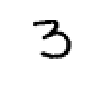

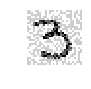

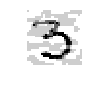

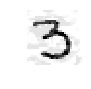

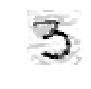

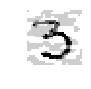

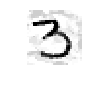

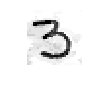

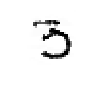

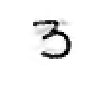

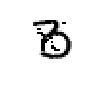

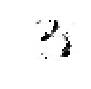

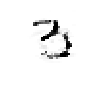

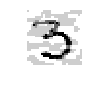

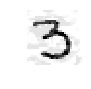

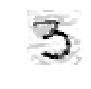

In [15]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(*input_shape))
visualize(noisy_data[x_vis].reshape(*input_shape))
visualize(fgsm_data[x_vis].reshape(*input_shape))
visualize(bim_a_data[x_vis].reshape(*input_shape))
visualize(bim_b_data[x_vis].reshape(*input_shape))
visualize(fgsm_wb_data[x_vis].reshape(*input_shape))
visualize(bim_a_wb_data[x_vis].reshape(*input_shape))
visualize(bim_b_wb_data[x_vis].reshape(*input_shape))
visualize(cw_data[x_vis].reshape(*input_shape))
visualize(df_data[x_vis].reshape(*input_shape))
visualize(jsma_data[x_vis].reshape(*input_shape))
visualize(p1_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data_fgsm[x_vis].reshape(*input_shape))
visualize(p2_cw_data_bim_a[x_vis].reshape(*input_shape))
visualize(p2_cw_data_bim_b[x_vis].reshape(*input_shape))

In [16]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
fgsm_wb_preds = model.model.predict(fgsm_wb_data.reshape(-1,*input_shape))
bim_a_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
bim_b_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))
p2_cw_fgsm_preds = model.model.predict(p2_cw_data_fgsm.reshape(-1,*input_shape))
p2_cw_bim_a_preds = model.model.predict(p2_cw_data_bim_a.reshape(-1,*input_shape))
p2_cw_bim_b_preds = model.model.predict(p2_cw_data_bim_b.reshape(-1,*input_shape))

In [17]:
#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
noisy_labels = preds_to_labels(noisy_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_a_labels = preds_to_labels(bim_a_preds)
bim_b_labels = preds_to_labels(bim_b_preds)
fgsm_wb_labels = preds_to_labels(fgsm_wb_preds)
bim_a_wb_labels = preds_to_labels(bim_a_wb_preds)
bim_b_wb_labels = preds_to_labels(bim_b_wb_preds)
cw_labels = preds_to_labels(cw_preds)
df_labels = preds_to_labels(df_preds)
jsma_labels = preds_to_labels(jsma_preds)
p1_cw_labels = preds_to_labels(p1_cw_preds)
p2_cw_labels = preds_to_labels(p2_cw_preds)
p2_cw_fgsm_labels = preds_to_labels(p2_cw_fgsm_preds)
p2_cw_bim_a_labels = preds_to_labels(p2_cw_bim_a_preds)
p2_cw_bim_b_labels = preds_to_labels(p2_cw_bim_b_preds)

In [18]:
#This is a large network, therefore we need to calculate cos_sim for one type and free memory
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)
grads_train = normalize(grads_train)
grads_reg_norms, cos_sim_reg = norms_and_cos(model, reg_data, reg_labels, grads_train)
grads_noisy_norms, cos_sim_noisy = norms_and_cos(model, noisy_data, noisy_labels, grads_train)
grads_fgsm_norms, cos_sim_fgsm =norms_and_cos(model, fgsm_data, fgsm_labels, grads_train)
grads_bim_a_norms, cos_sim_bim_a = norms_and_cos(model, bim_a_data, bim_a_labels, grads_train)
grads_bim_b_norms , cos_sim_bim_b= norms_and_cos(model, bim_b_data, bim_b_labels, grads_train)
grads_fgsm_wb_norms, cos_sim_fgsm_wb = norms_and_cos(model, fgsm_wb_data, fgsm_wb_labels, grads_train)
grads_bim_a_wb_norms, cos_sim_bim_a_wb = norms_and_cos(model, bim_a_wb_data, bim_a_wb_labels, grads_train)
grads_bim_b_wb_norms, cos_sim_bim_b_wb = norms_and_cos(model, bim_b_wb_data, bim_b_wb_labels, grads_train)
grads_cw_norms, cos_sim_cw = norms_and_cos(model, cw_data, cw_labels, grads_train)
grads_df_norms, cos_sim_df = norms_and_cos(model, df_data, df_labels, grads_train)
grads_jsma_norms, cos_sim_jsma = norms_and_cos(model, jsma_data, jsma_labels, grads_train)
grads_p1_cw_norms, cos_sim_p1_cw = norms_and_cos(model, p1_cw_data, p1_cw_labels, grads_train)
grads_p2_cw_norms, cos_sim_p2_cw = norms_and_cos(model, p2_cw_data, p2_cw_labels, grads_train)
grads_p2_cw_fgsm_norms, cos_sim_p2_cw_fgsm = norms_and_cos(model, p2_cw_data_fgsm, p2_cw_fgsm_labels, grads_train)
grads_p2_cw_bim_a_norms, cos_sim_p2_cw_bim_a = norms_and_cos(model, p2_cw_data_bim_a, p2_cw_bim_a_labels, grads_train)
grads_p2_cw_bim_b_norms, cos_sim_p2_cw_bim_b = norms_and_cos(model, p2_cw_data_bim_b, p2_cw_bim_b_labels, grads_train)

../models/util.py:44: RuntimeWarning: invalid value encountered in sqrt
  norms = np.sqrt(np.dot(grads, grads.T)).diagonal()


In [25]:
#Separate Using Cos Sim
eta = 0.7
print ('Regular: %.4f' % ( greater_cos(cos_sim_reg, eta)))
print ('Noisy:  %.4f' % ( greater_cos(cos_sim_noisy, eta)))
print ('FGSM:  %.4f' % ( greater_cos(cos_sim_fgsm, eta)))
print ('BIM-A:  %.4f' % ( greater_cos(cos_sim_bim_a, eta)))
print ('BIM-B:  %.4f' % ( greater_cos(cos_sim_bim_b, eta)))
print ('FGSM-WB:  %.4f' % ( greater_cos(cos_sim_fgsm_wb, eta)))
print ('BIM-A-WB:  %.4f' % ( greater_cos(cos_sim_bim_a_wb, eta)))
print ('BIM-B-WB:  %.4f' % ( greater_cos(cos_sim_bim_b_wb, eta)))
print ('CW: %.4f' % ( greater_cos(cos_sim_cw, eta)))
print ('DF: %.4f' % ( greater_cos(cos_sim_df, eta)))
print ('JSMA: %.4f' % ( greater_cos(cos_sim_jsma, eta)))
print ('1 Phase CW:  %.4f' % ( greater_cos(cos_sim_p1_cw, eta)))        
print ('2 Phase CW:  %.4f' % ( greater_cos(cos_sim_p2_cw, eta)))
print ('2 Phase CW FGSM:  %.4f' % ( greater_cos(cos_sim_p2_cw_fgsm, eta)))       
print ('2 Phase CW BIM-A:  %.4f' % ( greater_cos(cos_sim_p2_cw_bim_a, eta)))      
print ('2 Phase CW BIM-B:  %.4f' % ( greater_cos(cos_sim_p2_cw_bim_b, eta)))


Regular: 0.8800
Noisy:  0.5200
FGSM:  0.1800
BIM-A:  0.1100
BIM-B:  0.2700
FGSM-WB:  0.1500
BIM-A-WB:  0.7600
BIM-B-WB:  0.8400
CW: 0.0300
DF: 0.0200
JSMA: 0.0400
1 Phase CW:  0.2600
2 Phase CW:  0.0400
2 Phase CW FGSM:  0.1800
2 Phase CW BIM-A:  0.1100
2 Phase CW BIM-B:  0.2800


In [29]:
#Separate using just norm
gamma = .02
print ('Regular: %.4f' % ( smaller_norm(grads_reg_norms, gamma)))
print ('Noisy:  %.4f' % ( smaller_norm(grads_noisy_norms, gamma)))
print ('FGSM:  %.4f' % ( smaller_norm(grads_fgsm_norms, gamma)))
print ('BIM-A:  %.4f' % ( smaller_norm(grads_bim_a_norms, gamma)))
print ('BIM-B:  %.4f' % ( smaller_norm(grads_bim_b_norms, gamma)))
print ('FGSM-WB:  %.4f' % ( smaller_norm(grads_fgsm_wb_norms, gamma)))
print ('BIM-A-WB:  %.4f' % ( smaller_norm(grads_bim_a_wb_norms, gamma)))
print ('BIM-B-WB:  %.4f' % ( smaller_norm(grads_bim_b_wb_norms, gamma)))
print ('CW: %.4f' % ( smaller_norm(grads_cw_norms, gamma)))
print ('DF: %.4f' % ( smaller_norm(grads_df_norms, gamma)))
print ('JSMA: %.4f' % ( smaller_norm(grads_jsma_norms, gamma)))
print ('1 Phase CW:  %.4f' % ( smaller_norm(grads_p1_cw_norms, gamma)))        
print ('2 Phase CW:  %.4f' % ( smaller_norm(grads_p2_cw_norms, gamma)))
print ('2 Phase CW FGSM:  %.4f' % ( smaller_norm(grads_p2_cw_fgsm_norms, gamma)))       
print ('2 Phase CW BIM-A:  %.4f' % ( smaller_norm(grads_p2_cw_bim_a_norms, gamma)))      
print ('2 Phase CW BIM-B:  %.4f' % ( smaller_norm(grads_p2_cw_bim_b_norms, gamma)))


Regular: 0.8800
Noisy:  0.3800
FGSM:  0.1000
BIM-A:  0.0000
BIM-B:  0.6300
FGSM-WB:  0.2400
BIM-A-WB:  0.9400
BIM-B-WB:  1.0000
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW:  0.1900
2 Phase CW:  0.0000
2 Phase CW FGSM:  0.1000
2 Phase CW BIM-A:  0.0000
2 Phase CW BIM-B:  0.6000


In [30]:
#Use both cos and norm
print ('Regular: %.4f' % ( cos_and_norm_sep(cos_sim_reg, grads_reg_norms, eta, gamma)))
print ('Noisy:  %.4f' % ( cos_and_norm_sep(cos_sim_noisy, grads_noisy_norms, eta, gamma)))
print ('FGSM:  %.4f' % ( cos_and_norm_sep(cos_sim_fgsm, grads_fgsm_norms, eta, gamma)))
print ('BIM-A:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_a, grads_bim_a_norms, eta, gamma)))
print ('BIM-B:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_b, grads_bim_b_norms, eta, gamma)))
print ('FGSM-WB:  %.4f' % ( cos_and_norm_sep(cos_sim_fgsm_wb, grads_fgsm_wb_norms, eta, gamma)))
print ('BIM-A-WB:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_a_wb, grads_bim_a_wb_norms, eta, gamma)))
print ('BIM-B-WB:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_b_wb, grads_bim_b_wb_norms, eta, gamma)))
print ('CW: %.4f' % ( cos_and_norm_sep(cos_sim_cw, grads_cw_norms, eta, gamma)))
print ('DF: %.4f' % ( cos_and_norm_sep(cos_sim_df, grads_df_norms, eta, gamma)))
print ('JSMA: %.4f' % ( cos_and_norm_sep(cos_sim_jsma, grads_jsma_norms, eta, gamma)))
print ('1 Phase CW: %.4f' % ( cos_and_norm_sep(cos_sim_p1_cw, grads_p1_cw_norms, eta, gamma)))
print ('2 Phase CW: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw, grads_p2_cw_norms, eta, gamma)))
print ('2 Phase CW FGSM: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_fgsm, grads_p2_cw_fgsm_norms, eta, gamma)))
print ('2 Phase CW BIM A: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_bim_a, grads_p2_cw_bim_a_norms, eta, gamma)))
print ('2 Phase CW BIM B: %.4f' % ( cos_and_norm_sep(cos_sim_p2_cw_bim_b, grads_p2_cw_bim_b_norms, eta, gamma)))


Regular: 0.7900
Noisy:  0.2400
FGSM:  0.0100
BIM-A:  0.0000
BIM-B:  0.1500
FGSM-WB:  0.0600
BIM-A-WB:  0.7200
BIM-B-WB:  0.8400
CW: 0.0000
DF: 0.0000
JSMA: 0.0000
1 Phase CW: 0.1300
2 Phase CW: 0.0000
2 Phase CW FGSM: 0.0100
2 Phase CW BIM A: 0.0000
2 Phase CW BIM B: 0.1400


In [31]:
#Get distortion
print ('Noisy: %.5f' % (avg_l2_dist(reg_data, noisy_data)))
print ('FGSM: %.5f' % (avg_l2_dist(reg_data, fgsm_data)))
print ('BIM-A: %.5f' % (avg_l2_dist(reg_data, bim_a_data)))
print ('BIM-B: %.5f' % (avg_l2_dist(reg_data, bim_b_data)))
print ('FGSM-WB: %.5f' % (avg_l2_dist(reg_data, fgsm_wb_data)))
print ('BIM-A-WB: %.5f' % (avg_l2_dist(reg_data, bim_a_wb_data)))
print ('BIM-B-WB: %.5f' % (avg_l2_dist(reg_data, bim_b_wb_data)))
print ('CW: %.5f' % (avg_l2_dist(reg_data, cw_data)))
print ('DF: %.5f' % (avg_l2_dist(reg_data, df_data)))
print ('JSMA: %.5f' % (avg_l2_dist(reg_data, jsma_data)))
print ('P1-CW: %.5f' % (avg_l2_dist(reg_data, p1_cw_data)))
print ('P2-CW: %.5f' % (avg_l2_dist(reg_data, p2_cw_data)))
print ('P2-CW FGSM: %.5f' % (avg_l2_dist(reg_data, p2_cw_data_fgsm)))
print ('P2-CW BIM A: %.5f' % (avg_l2_dist(reg_data, p2_cw_data_bim_a)))
print ('P2-CW BIM B: %.5f' % (avg_l2_dist(reg_data, p2_cw_data_bim_b)))


Noisy: 6.12913
FGSM: 5.75833
BIM-A: 2.60660
BIM-B: 4.64218
FGSM-WB: 6.12738
BIM-A-WB: 3.26871
BIM-B-WB: 3.34184
CW: 2.59682
DF: 1.74142
JSMA: 4.88954
P1-CW: 5.78828
P2-CW: 3.29436
P2-CW FGSM: 5.75833
P2-CW BIM A: 2.60660
P2-CW BIM B: 4.63683


In [32]:
#Ratio of perturbed samples having cos sim greater
print ('Noisy:  %.4f' % ( comp_cos(cos_sim_noisy, cos_sim_reg)))
print ('FGSM:  %.4f' % ( comp_cos(cos_sim_fgsm, cos_sim_reg)))
print ('BIM-A:  %.4f' % ( comp_cos(cos_sim_bim_a, cos_sim_reg)))
print ('BIM-B:  %.4f' % ( comp_cos(cos_sim_bim_b, cos_sim_reg)))
print ('FGSM-WB:  %.4f' % ( comp_cos(cos_sim_fgsm_wb, cos_sim_reg)))
print ('BIM-A-WB:  %.4f' % ( comp_cos(cos_sim_bim_a_wb, cos_sim_reg)))
print ('BIM-B-WB:  %.4f' % ( comp_cos(cos_sim_bim_b_wb, cos_sim_reg)))
print ('CW: %.4f' % ( comp_cos(cos_sim_cw, cos_sim_reg)))
print ('DF: %.4f' % ( comp_cos(cos_sim_df, cos_sim_reg)))
print ('JSMA: %.4f' % ( comp_cos(cos_sim_jsma, cos_sim_reg)))
print ('1 Phase CW:  %.4f' % ( comp_cos(cos_sim_p1_cw, cos_sim_reg)))
print ('2 Phase CW:  %.4f' % ( comp_cos(cos_sim_p2_cw, cos_sim_reg)))
print ('2 Phase CW FGSM:  %.4f' % ( comp_cos(cos_sim_p2_cw_fgsm, cos_sim_reg)))
print ('2 Phase CW BIM A:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_a, cos_sim_reg)))
print ('2 Phase CW BIM B:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_b, cos_sim_reg)))

Noisy:  0.1600
FGSM:  0.0500
BIM-A:  0.0600
BIM-B:  0.0400
FGSM-WB:  0.0500
BIM-A-WB:  0.3500
BIM-B-WB:  0.2900
CW: 0.0500
DF: 0.0400
JSMA: 0.0500
1 Phase CW:  0.0600
2 Phase CW:  0.0300
2 Phase CW FGSM:  0.0500
2 Phase CW BIM A:  0.0600
2 Phase CW BIM B:  0.0400


In [33]:
#Ratio of perturbed samples having cos sim greater
print ('Noisy:  %.4f' % ( comp_norm(grads_noisy_norms, grads_reg_norms)))
print ('FGSM:  %.4f' % ( comp_norm(grads_fgsm_norms, grads_reg_norms)))
print ('BIM-A:  %.4f' % ( comp_norm(grads_bim_a_norms, grads_reg_norms)))
print ('BIM-B:  %.4f' % ( comp_norm(grads_bim_b_norms, grads_reg_norms)))
print ('CW: %.4f' % ( comp_norm(grads_cw_norms, grads_reg_norms)))
print ('DF: %.4f' % ( comp_norm(grads_df_norms, grads_reg_norms)))
print ('JSMA: %.4f' % ( comp_norm(grads_jsma_norms, grads_reg_norms)))
print ('1 Phase CW: %.4f' % ( comp_norm(grads_p1_cw_norms, grads_reg_norms)))
print ('2 Phase CW: %.4f' % ( comp_norm(grads_p2_cw_norms, grads_reg_norms)))
print ('2 Phase CW FGSM: %.4f' % ( comp_norm(grads_p2_cw_fgsm_norms, grads_reg_norms)))
print ('2 Phase CW BIM A: %.4f' % ( comp_norm(grads_p2_cw_bim_a_norms, grads_reg_norms)))
print ('2 Phase CW BIM B: %.4f' % ( comp_norm(grads_p2_cw_bim_b_norms, grads_reg_norms)))

Noisy:  0.9800
FGSM:  0.9300
BIM-A:  1.0000
BIM-B:  0.6800
CW: 1.0000
DF: 1.0000
JSMA: 1.0000
1 Phase CW: 0.9700
2 Phase CW: 1.0000
2 Phase CW FGSM: 0.9300
2 Phase CW BIM A: 1.0000
2 Phase CW BIM B: 0.6900
